## Predicting rate with unsupervised approach

In [1]:
# import necessary packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.inspection import permutation_importance
import eli5
from eli5.sklearn import PermutationImportance

from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KernelDensity
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA

from scipy import stats
from scipy.stats import spearmanr

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# read in data generated in tutor_cleaning
df_eng = pd.read_csv('/Users/NewUser/Documents/GitHub/tutor_prediction/tutor_prediction/data/tutor_data.csv').drop(columns='Unnamed: 0')
df_eng.reset_index(drop=True, inplace=True)

# read in features engineered in tutor_nlp
df_nlp = pd.read_csv('/Users/NewUser/Documents/GitHub/tutor_prediction/tutor_prediction/data/tutor_nlp.csv')
df_eng = pd.concat([df_eng, df_nlp], axis=1)

# cuts on targets

#df_eng = df_eng.loc[df_eng[df_eng['hours_per_week_estimate'] < 20].index]
#df_eng = df_eng.loc[df_eng[df_eng['hours_per_week_estimate'] > 0.5].index]
#df_eng = df_eng.loc[df_eng[df_eng['hours_tutor'] <= 1000].index]

#df_eng = df_eng.loc[df_eng[df_eng['rate'] <= 200].index]
#df_eng = df_eng.loc[df_eng[df_eng['rate'] >= 20].index]
#df_eng.drop_duplicates(inplace=True)

In [3]:
df_eng.hours_tutor.describe()

count     4484.00000
mean       563.01182
std       1047.21002
min          1.00000
25%         51.00000
50%        172.00000
75%        596.25000
max      14999.00000
Name: hours_tutor, dtype: float64

#### histogram and kernel density distribution for rate

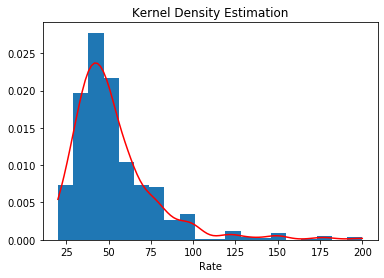

In [4]:
plt.hist(df_eng.rate, bins=20, range=(20,200), density=True)
plt.xlabel('Rate')
gkde = stats.gaussian_kde(df_eng.rate, bw_method = None, weights=None)
ind = np.linspace(20, 200, 101)
kdepdf = gkde.evaluate(ind)
plt.plot(ind, kdepdf, label='unweighted', color="r")
plt.title('Kernel Density Estimation')
#plt.legend()
plt.savefig('kde-rate.png', dpi=100)
plt.show()

### Now engineer relevant features from subjects, education such as number_popular_subjects, top_school, etc.

In [5]:
# use function to parse lists typecast as strings from scraped data
def string_to_list(i):
    x = i.replace('[', '').replace(']', '').replace('\'', '').split(',')
    list_i = list()
    for j in x:
        list_i.append(j.lstrip().rstrip())
    return list_i

subjects_all_list = []
for i in df_eng['subjects_all']:
    subjects_all_list.append(string_to_list(i))
df_eng['subjects_list'] = np.array(subjects_all_list)

subjects_emph_list = []
for i in df_eng['subjects_emph']:
    subjects_emph_list.append(string_to_list(i))
df_eng['subjects_emph_list'] = np.array(subjects_emph_list)

#edu_list = []
#for i in df_eng['edu']:
#    edu_list.append(string_to_list(i))
#df_eng['edu_list'] = np.array(edu_list)

# subjects categories based on popularity
feature = 'subjects_list'
size_subjects = len(df_eng[feature].explode().value_counts().index)
popular_subjects = list(df_eng[feature].explode().value_counts().index[:size_subjects//3])
mid_subjects = list(df_eng[feature].explode().value_counts().index[size_subjects//3:(size_subjects//3 + size_subjects//3)])
unpopular_subjects = list(df_eng[feature].explode().value_counts().index[(size_subjects//3 + size_subjects//3):])

# remove unwanted subjects
unwanted = ''
if unwanted in popular_subjects:
    popular_subjects.remove(unwanted)
elif unwanted in mid_subjects:
    mid_subjects.remove(unwanted)
elif unwanted in unpopular_subjects:
    unpopular_subjects.remove(unwanted)
    
# engineer subject features based on popularity
popular_list = []
mid_list = []
unpopular_list = []
for f in df_eng[feature]:
    num_popular = 0
    num_mid = 0
    num_unpopular = 0
    for j in f:
        if j in popular_subjects:
            num_popular += 1
        elif j in mid_subjects:
            num_mid += 1
        elif j in unpopular_subjects:
            num_unpopular += 1
    popular_list.append(num_popular)
    mid_list.append(num_mid)
    unpopular_list.append(num_unpopular)

df_eng['num_popular_subjects'] = np.array(popular_list)
df_eng['num_mid_subjects'] = np.array(mid_list)
df_eng['num_unpopular_subjects'] = np.array(unpopular_list)

# engineer edu degree categories
undergrad = ['BA', 'B.A.', 'BS', 'B.S.', '']
postgrad = ['MS', 'M.S', 'MA', 'M.A', 'masters', 'Masters', 'CA', 'C.A', 
            'MBA', 'M.B.A', 'MD', 'M.D', 'PhD', 'Ph.D', 'Ph.D.', 'Graduate']
certified = ['education', 'Ced', 'certified']

undergrad_degree = []
postgrad_degree = []
certified_degree = []
for e in df_eng['edu']:
    undergrad_count = 0
    postgrad_count = 0
    certified_count = 0
    if any(x in e for x in undergrad):
        undergrad_count += 1
    if any(x in e for x in postgrad):
        postgrad_count += 1
    if any(x in e for x in certified):
        certified_count +=1
    undergrad_degree.append(undergrad_count)
    postgrad_degree.append(postgrad_count)
    certified_degree.append(certified_count)
df_eng['undergrad_degree'] = np.array(undergrad_degree)
df_eng['postgrad_degree'] = np.array(postgrad_degree)
df_eng['certified_degree'] = np.array(certified_degree)

# get university rankings, using WUR dataset in csv
df_wur = pd.read_csv('/Users/NewUser/Documents/GitHub/tutor_prediction/tutor_prediction/data/world-university-rankings_cwurData.csv')
df_wur_select = df_wur[['institution', 'world_rank']]

list_of_top_schools = (list(df_wur_select['institution'][:30]) + 
['Berkeley', 'Caltech', 'Harvard', 'Yale', 'Princeton', 'MIT', 'Stanford'])

# engineer top school feature
top_school = []
for e in df_eng['edu']:
    top = 0
    if any(x in e for x in list_of_top_schools):
        top += 1
    top_school.append(top)
df_eng['top_school'] = np.array(top_school)

df_eng['bio_count'] = df_eng['bio'].apply(lambda x: len(str(x).split(" ")))
df_eng['desc_count'] = df_eng['descriptions'].apply(lambda x: len(str(x).split(" ")))

### drop undesired columns, generate feature matrix X and target y

In [6]:
cols_to_drop = ['descriptions', 'bio', 'subjects_list', 'subjects_emph_list', 
                'edu', 'bg_check_date', 'earliest_review_date', 
                'subjects_emph', 'subjects_all','hours_tutor', 
                'num_ratings', 'review_dates', 'earliest_date','undergrad_degree',
               'hours_mon', 'hours_tues', 'hours_wed', 'hours_thurs', 'hours_fri']

X = df_eng.drop(columns=(['rate', 'hours_per_week_estimate'] + cols_to_drop))
y = df_eng.rate

#Take the log of y
y_log = np.log10(y)

#rescale data
X = (X - X.min()) / (X.max()-X.min())

features = X.columns

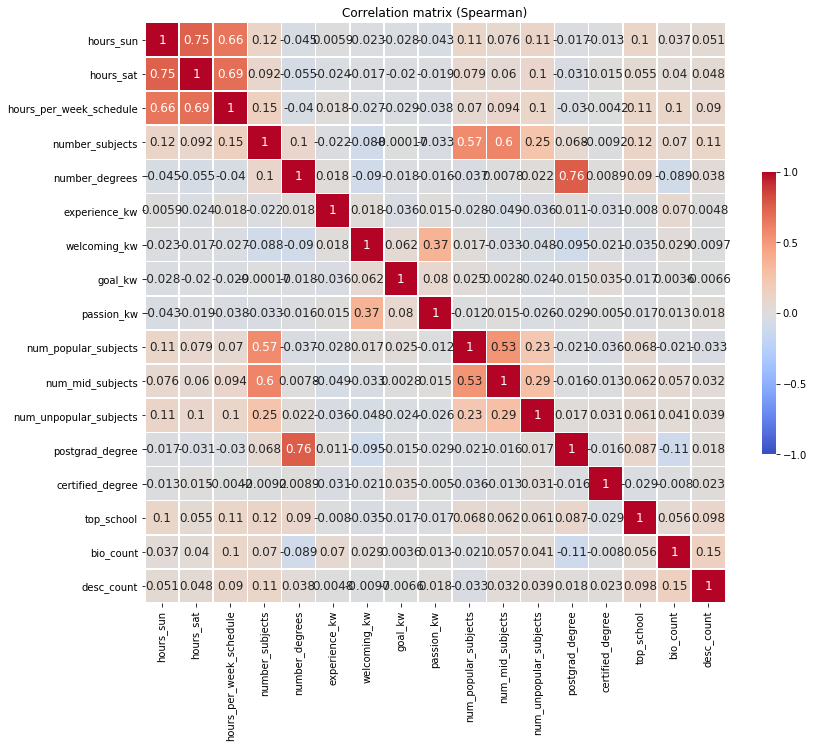

In [7]:
# Plot Spearman Correlation matrix

fig, ax = plt.subplots(figsize=(13, 13)) 

spearman_corr = pd.DataFrame(spearmanr(X).correlation, index=features, columns=features)

spearman_heatmap = sns.heatmap(spearman_corr,
                     square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4, 
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1, 
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': 12})
ax.set_yticklabels(spearman_corr.columns, rotation = 0)
ax.set_xticklabels(spearman_corr.columns)
ax.set_title('Correlation matrix (Spearman)')
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

#### First fit a regularized regression model 

r^2:  0.11401607684486303


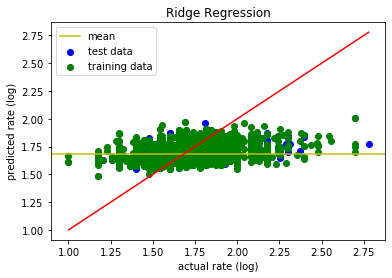

In [8]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=0)
reg_model = Ridge(alpha=1e-2).fit(X_train, y_train)
y_predict = reg_model.predict(X_test)
y_fit = reg_model.predict(X_train)

# get r^2 score, scatterplot of actual target, predicted target and mean
print('r^2: ', r2_score(y_test, y_predict))

plt.scatter(np.array(y_test), y_predict, color='b', label='test data')
plt.scatter(np.array(y_train), y_fit, color='g', label='training data')
plt.axhline(y=y_log.mean(), color='y', linestyle='-', label='mean')
x = np.linspace(y_log.min(), y_log.max(),100)
plt.plot(x, x, '-r')
plt.legend()
plt.title('Ridge Regression')
plt.xlabel('actual rate (log)')
plt.ylabel('predicted rate (log)')
plt.show()

### Now try a random forest regressor

In [26]:
list(X.columns)

['hours_sun',
 'hours_sat',
 'hours_per_week_schedule',
 'number_subjects',
 'number_degrees',
 'experience_kw',
 'welcoming_kw',
 'goal_kw',
 'passion_kw',
 'num_popular_subjects',
 'num_mid_subjects',
 'num_unpopular_subjects',
 'postgrad_degree',
 'certified_degree',
 'top_school',
 'bio_count',
 'desc_count']

In [36]:
feat_corr = ['hours_per_week_schedule',
 'number_subjects',
 'number_degrees',
 'experience_kw',
 'welcoming_kw',
 'goal_kw',
 'passion_kw',
 'num_popular_subjects',
 'certified_degree',
 'top_school',
 'bio_count',
 'desc_count']
X = X[feat_corr]

r^2:  0.2147699926927481


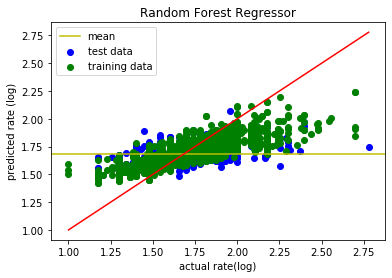

In [37]:
# Initialize random forest model, set hyperparameters
rf = RandomForestRegressor(n_estimators=100, criterion='mse', random_state=0, min_samples_leaf = 5)

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=0)
rf.fit(X_train, y_train)
y_predict = rf.predict(X_test)
y_fit = rf.predict(X_train)

# get r^2 score, scatterplot of actual target, predicted target and mean

print('r^2: ', r2_score(y_test, y_predict))
plt.scatter(np.array(y_test), y_predict, color='b', label='test data')
plt.scatter(np.array(y_train), y_fit, color='g', label='training data')
plt.axhline(y=y_log.mean(), color='y', linestyle='-', label='mean')
x = np.linspace(y_log.min(), y_log.max(),100)
plt.plot(x, x, '-r')
plt.legend()
plt.title('Random Forest Regressor')
plt.xlabel('actual rate(log)')
plt.ylabel('predicted rate (log)')
plt.savefig('rf-rate.png', dpi=100)
plt.show()

### Calculate impurity and permutation features importances based on random forest regressor

Feature ranking:
feature bio_count (0.21)
feature hours_per_week_schedule (0.20)
feature number_subjects (0.18)
feature num_popular_subjects (0.11)
feature desc_count (0.10)
feature top_school (0.09)
feature number_degrees (0.05)
feature experience_kw (0.02)
feature welcoming_kw (0.02)
feature passion_kw (0.02)
feature goal_kw (0.00)
feature certified_degree (0.00)


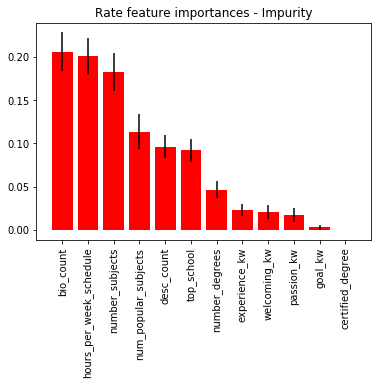

In [38]:
rf = RandomForestRegressor(n_estimators=100, criterion='mse', random_state=0, min_samples_leaf = 5)
features = list(X.columns)
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=0)
rf.fit(X_train, y_train)

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print feature ranking
print("Feature ranking:")
test = [features[f] for f in indices]
for f in range(X.shape[1]):
    print("feature %s (%.2f)" %(test[f], importances[indices[f]]))

# Plot feature importances of the forest
plt.figure()
plt.title("Rate feature importances - Impurity")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), test, rotation='90')
plt.xlim([-1, X.shape[1]])
plt.savefig('impurity-rate.png', bbox_inches = "tight", dpi=100)
plt.show()

In [39]:
rf = RandomForestRegressor(n_estimators=100, criterion='mse', random_state=0, min_samples_leaf = 5)
features = list(X.columns)
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=0)
rf.fit(X_train, y_train)

perm = PermutationImportance(rf, random_state=1).fit(X_test, y_test)
perm.fit(X_test, y_test)

j = eli5.show_weights(perm, feature_names = X_test.columns.tolist())
j

Weight,Feature
0.1658 ± 0.0304,number_subjects
0.1234 ± 0.0432,top_school
0.0801 ± 0.0198,hours_per_week_schedule
0.0794 ± 0.0279,bio_count
0.0589 ± 0.0132,number_degrees
0.0582 ± 0.0125,desc_count
0.0381 ± 0.0089,num_popular_subjects
0.0148 ± 0.0073,experience_kw
0.0088 ± 0.0018,passion_kw
0.0080 ± 0.0054,welcoming_kw


####  Select important features, output dataframe to csv

In [40]:
important_features = ['number_subjects', 'top_school', 'hours_per_week_schedule', 
'bio_count', 'number_degrees', 'desc_count', 'num_popular_subjects']
df_eng[important_features + ['rate']].to_csv('/Users/NewUser/Documents/GitHub/tutor_prediction/tutor_prediction/data/tutor_data_rate.csv')

### Setup pipeline for scaling + PCA

In [41]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df_eng[important_features])
pca = PCA(n_components=3)
test_pca = pca.fit_transform(scaled_df)

#test input
input_test = np.array([-0.2, 0.2, 0])
weights_test = (1. / np.linalg.norm(input_test - test_pca, axis=-1))

#### Generate KDE for test input

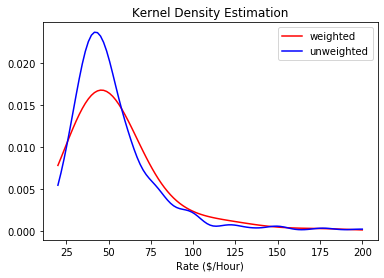

In [42]:
gkde_weight = stats.gaussian_kde(df_eng.rate, bw_method = 0.5, weights=weights_test**2)
#gkde_weight = stats.gaussian_kde(df_eng.rate, bw_method = 0.5, weights=np.ones(len(df_eng.rate)))
ind = np.linspace(20, 200, 101)
kdepdf_weights = gkde_weight.evaluate(ind)
#plt.figure()
plt.plot(ind, kdepdf_weights, label='weighted', color="r")
plt.title('Kernel Density Estimation')
plt.xlabel('Rate ($/Hour)')
plt.plot(ind, kdepdf, label='unweighted', color='b')
plt.legend()
plt.savefig('kde-rate_ex.png', dpi=100)
plt.show()

#### Check performance on kNN to determine optimal number of components to use

In [43]:
scaler = StandardScaler()
r2_scores = []
scaled_df = scaler.fit_transform(df_eng[important_features])
for i in range(1,6):
    pca = PCA(n_components=i)
    test_pca = pca.fit_transform(scaled_df)
    #print('Variance explained with', i, 'components:',  pca.explained_variance_ratio_.sum())
    knn = KNeighborsRegressor(weights='distance', n_neighbors = 5)
    X_train, X_test, y_train, y_test = train_test_split(test_pca, y_log, test_size=0.2, random_state=0)
    knn.fit(X_train, y_train)
    y_predict = knn.predict(X_test)
    #print(i, ' features has a validation score ', r2_score(y_test, y_predict))
    r2_scores.append(r2_score(y_test, y_predict))

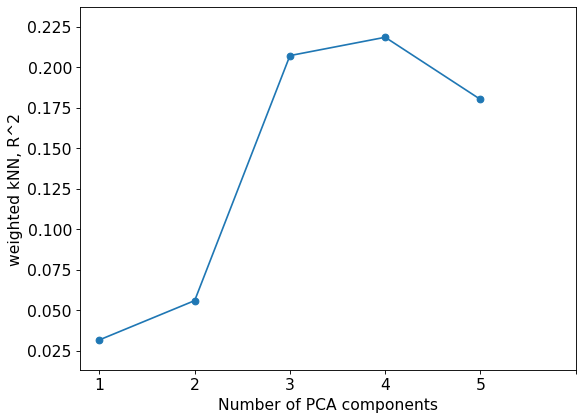

In [56]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.scatter([1,2,3,4, 5], r2_scores)
plt.plot([1,2,3,4, 5], r2_scores)
plt.xlabel('Number of PCA components', fontsize=14)
plt.xticks(ticks=[1,2,3,4,5,6], labels=[1,2,3,4,5], fontsize=14)
plt.ylabel('weighted kNN, R^2', fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('kNN-rate.png', dpi=100)
plt.show()